In [95]:
# Import libraries
## data
import os
import pandas as pd
import numpy as np
## model 
import torch
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.functional import pad
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# plot
import matplotlib.pyplot as plt
import seaborn as sns

## Data

### Load

In [96]:
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def parse_emotion_from_filename(filename):
    emotion_code = filename.split('-')[2]
    return emotion_map.get(emotion_code, 'unknown')

# Collect all files and labels
def load_filepaths_and_labels(audio_dir):
    data = []
    for root, _, files in os.walk(audio_dir):
        for f in files:
            if f.endswith('.wav'):
                full_path = os.path.join(root, f)
                emotion = parse_emotion_from_filename(f)
                actor = root.split("\\")[-1]
                data.append((full_path, actor, f, emotion))
    return pd.DataFrame(data, columns=['path', 'actor', 'file', 'emotion'])


In [97]:
current_path = os.getcwd()
data_path = os.path.join(current_path, "data")

In [98]:
df = load_filepaths_and_labels(data_path)

### Class to process data

In [99]:
class EmotionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.label2idx = {label: idx for idx, label in enumerate(sorted(df['emotion'].unique()))}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx]['path']
        label = self.df.iloc[idx]['emotion']

        # Load audio
        waveform, sr = torchaudio.load(path)

        # Force to mono if stereo
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        # Optional: resample
        if sr != 16000:
            resampler = T.Resample(orig_freq=sr, new_freq=16000)
            waveform = resampler(waveform)
            sr = 16000

        # Apply transform (e.g. MFCC)
        if self.transform:
            waveform = self.transform(waveform)
        else:
            waveform = waveform

        return waveform, self.label2idx[label]
        # path = self.df.iloc[idx]['path']
        # label = self.df.iloc[idx]['emotion']
        # waveform, sr = torchaudio.load(path)
        # if self.transform:
        #     waveform = self.transform(waveform)
        # return waveform, self.label2idx[label]


### Transform data

In [100]:
mfcc_transform = T.MFCC(
    sample_rate=16000,
    n_mfcc=40,
    melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 64}
)

# Resample if needed
resampler = T.Resample(orig_freq=48000, new_freq=16000)  # optional if not 16kHz

def full_transform(waveform):
    if waveform.shape[1] > 0:
        waveform = resampler(waveform)
    return mfcc_transform(waveform)

## Model

### Train and validation split

In [101]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['emotion'], random_state=42)

### Emotion Dataset format adn Data Loader

In [102]:
# I add the collate to equlize audio files
# An alterantive would be (a) to reduce longer audios or (b) to pad shoter audios
def collate_fn(batch):
    # batch = list of (mfcc_tensor, label)
    mfccs = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    # Find max time dimension
    max_len = max([x.shape[-1] for x in mfccs])

    # Pad each MFCC to max_len
    mfccs_padded = [
        pad(x, (0, max_len - x.shape[-1]))  # pad last dim (time)
        for x in mfccs
    ]

    mfccs_tensor = torch.stack(mfccs_padded)
    labels_tensor = torch.tensor(labels)

    return mfccs_tensor, labels_tensor

In [103]:
train_dataset = EmotionDataset(train_df, transform=full_transform)
val_dataset = EmotionDataset(val_df, transform=full_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

### Define the model

In [104]:
class CNNEmotionClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.net(x)

### Train the model

In [105]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNEmotionClassifier(num_classes=len(train_dataset.label2idx)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x)
        loss = loss_fn(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} done. Loss: {loss.item():.4f}")

Epoch 1 done. Loss: 1.8919
Epoch 2 done. Loss: 1.9112
Epoch 3 done. Loss: 1.7621
Epoch 4 done. Loss: 1.8636
Epoch 5 done. Loss: 1.7509
Epoch 6 done. Loss: 1.7732
Epoch 7 done. Loss: 1.7108
Epoch 8 done. Loss: 1.4848
Epoch 9 done. Loss: 1.5677
Epoch 10 done. Loss: 1.6232


### Test the model

In [109]:
# Put model in evaluation mode
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

In [110]:
# Accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.3420


In [111]:
# Detailed report
print(classification_report(all_labels, all_preds, target_names=train_dataset.label2idx.keys()))

              precision    recall  f1-score   support

       angry       0.66      0.55      0.60        76
        calm       0.75      0.23      0.36        77
     disgust       0.27      0.08      0.12        77
     fearful       0.33      0.34      0.33        77
       happy       0.00      0.00      0.00        77
     neutral       0.00      0.00      0.00        38
         sad       0.23      0.39      0.29        77
   surprised       0.29      0.97      0.45        77

    accuracy                           0.34       576
   macro avg       0.32      0.32      0.27       576
weighted avg       0.34      0.34      0.29       576



c:\Users\alvar\miniconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\alvar\miniconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\alvar\miniconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

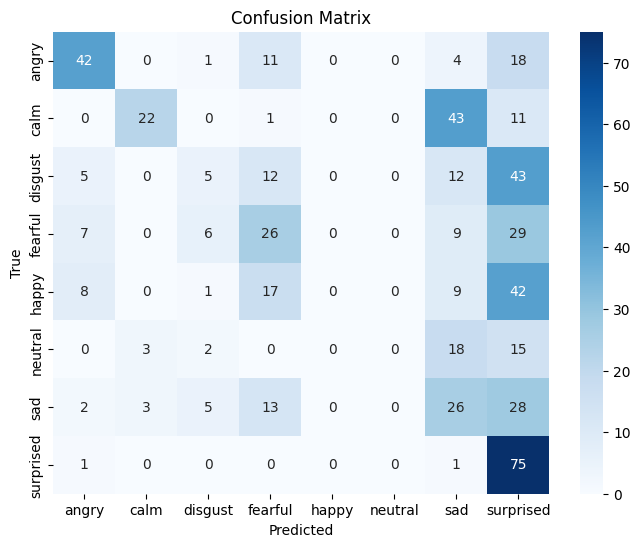

In [108]:
cm = confusion_matrix(all_labels, all_preds)
labels = list(train_dataset.label2idx.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()